# PyLamp - DIY Neural Network

Julien CANITROT (3803521), Jules DUBREUIL (3800417)

# 0. Imports & Helpers

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt

from lamp import *
from lamp.models import *
from lamp.utils import *

In [86]:
def analyse_compression(model, datax, datay, dtype="mnist", title="", classes=range(10)):
    decoded = model.predict(datax)
    nb_classes = len(classes)

    show = show_mnist if dtype == "mnist" else show_usps

    examples = np.zeros(nb_classes, dtype=np.int64)
    for i, v in enumerate(classes):
        examples[i] = np.where(datay == v)[0][0]

    plt.figure(figsize=(12, 3))
    for i, x in enumerate(examples):
        plt.subplot(2, nb_classes, i + 1)
        show(datax[x])
        plt.subplot(2, nb_classes, i + nb_classes + 1)
        show(decoded[x])

    plt.suptitle(title)
    plt.show()

# 1. Introduction

PyLamp fournit une API simple qui permet aux utilisateurs "moyens" de créer 
et d'entraîner des réseaux de neurones. Son implémentation s'inspire des
anciennes versions de PyTorch qui permettent la création de réseaux
très génériques et modulaires. Chaque couche du réseau est un module,
et le réseau peut être vu comme une succession de modules. Ainsi, les
fonctions d'activation sont aussi considérées comme des modules.

Cette librairie a été codée "à la main" (et Numpy), en évitant au maximum les boucles python connues pour être extremenet lentes.

# 2. Modèles

## Linear Regression

La première partie de ce projet consistait en l'implémentation de modèles simples. Le but étant de vérifier la bonne implémentation des premiers modules essentiels. Ils servent de base pour toutes les architectures de réseaux de neurones qui suivront.

In [52]:
# coefficient directeur généré aléatoirement
a = round(rd.random() * 100, 2)
sigma = a / 2

xtrain = np.linspace(0, 2, 100).reshape(-1, 1)
ytrain = xtrain * a + np.random.uniform(-sigma, sigma, (100,1))

In [53]:
linreg = LinearRegression()
linreg.fit(xtrain, ytrain, nb_iter=1000, gradient_step=1e-5)

coef: 27.22
predicted: 28.27


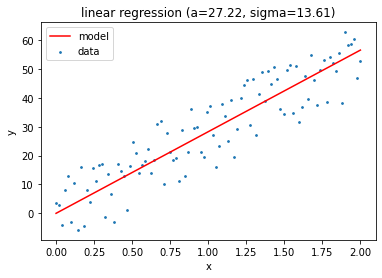

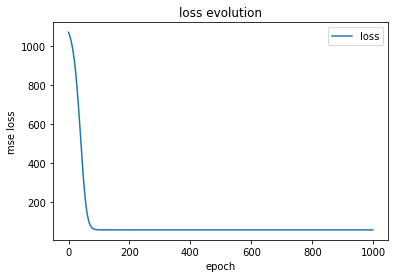

In [54]:
ahat = round(linreg.net._parameters[0][0], 2)
print(f"coef: {a}\npredicted: {ahat}")

plt.figure()
plt.title(f"linear regression (a={a}, sigma={sigma})")
plt.scatter(xtrain, ytrain, s=3, label="data")
plt.plot(xtrain, ahat * xtrain, color='red', label="model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig("plots/linear_regression/linreg.png")

plt.figure()
plt.title("loss evolution")
plt.plot(linreg.loss_list, label="loss")
plt.xlabel("epoch")
plt.ylabel("mse loss")
plt.legend()
plt.savefig("plots/linear_regression/linreg_loss.png")

plt.show()

Ce premier modèle linéaire très simple, permet de résoudre assez aisément les problèmes de régression linéaires.

## Non-Linear

Nous avons aussi vérifier les capacité non-linéares de nos modèles sur des problèmes tels que XOR.

In [55]:
datax, datay = gen_arti(data_type=1)
datay = np.where(datay == -1, 0, 1)
print(f"batch : {datax.shape[0]}")

batch : 1000


score: 0.999


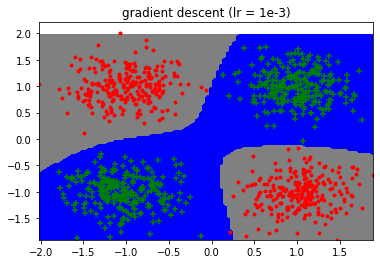

In [56]:
nonlin = NonLinear()
nonlin.fit(datax, datay, hidden=20, nb_iter=1000, gradient_step=1e-3)
yhat = nonlin.predict(datax)
print(f"score: {nonlin.score(datax, datay)}")

plot_frontiere(datax, nonlin.predict, step=100)
plot_data(datax, datay.flatten())
plt.title(f"gradient descent (lr = 1e-3)")
plt.savefig(f"plots/non_linear/nonlin_gd.png")
plt.show()

Nous en avons profité pour tester l'optimisation SGD qui offrent les mêmes résultats
~2 fois plus vite.

C:\Users\Jules Dubreuil\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3515: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\Jules Dubreuil\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


score: 0.997


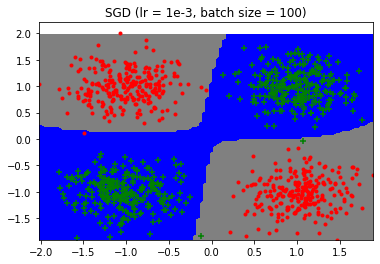

In [57]:
nonlin = NonLinear()
nonlin.fit(datax, datay, hidden=20, nb_iter=2000, gradient_step=1e-3, batch_size=100)
yhat = nonlin.predict(datax)
print(f"score: {nonlin.score(datax, datay)}")

plot_frontiere(datax, nonlin.predict, step=100)
plot_data(datax, datay.flatten())
plt.title(f"SGD (lr = 1e-3, batch size = 100)")
plt.savefig(f"plots/non_linear/nonlin_sgd.png")
plt.show()

## Multi-class

Une fois ces premiers résultats confirmés, intéressons-nous à présent à des problèmes de classifications nécessitant beaucoup plus de données.
Ici il s’agit de réussir à identifier à quelle classe appartient une image parmi 10 possibilités (0-10). Ce problème est plus intéressant puique les optimisations peuvent déjà faire une grande différence.

In [91]:
(train_X, train_y), (test_X, test_y) = load_mnist()
onehot = to_onehot(train_y)

Nous avons pu tester quelques architectures afin d'en déterminer les plus satisfaisantes. 
Voici quelques-uns de nos résultats avec différentes fonctions, tailles de batch et des couches cachées... 


In [59]:
mc = MultiClass()
mc.fit(train_X, onehot, hidden=100, nb_iter=100, gradient_step=1e-2)

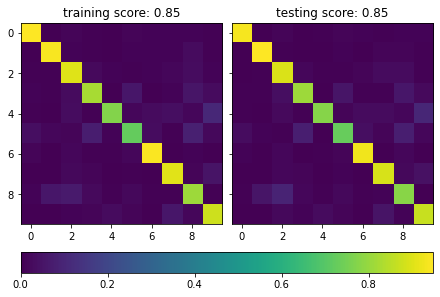

In [60]:
cms, scores = compare_mc_perf(mc, train_X, train_y, test_X, test_y)
plot_perf(cms, scores, "confusion_matrix.png")
plt.savefig("plots/classifier/confusion_matrix_100.png")

In [62]:
mc300 = MultiClass()
mc300.fit(train_X, onehot, hidden=300, nb_iter=100, gradient_step=1e-2)

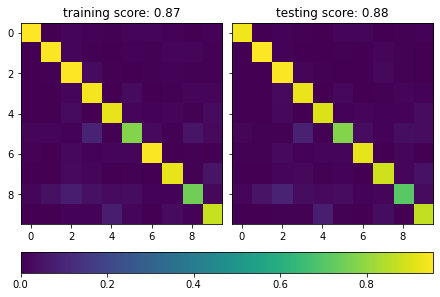

In [63]:
cms300, scores300 = compare_mc_perf(mc300, train_X, train_y, test_X, test_y)
plot_perf(cms300, scores300, "confusion_matrix300.png")
plt.savefig("plots/classifier/confusion_matrix_300.png")

On remarque que plus le nombre de neurones cachés est grand, meilleurs sont les résultats. Cependant il faut faire attention car une taille trop grande par rapport au nombre de données peut mener à du surapprentissage.
Nous obtenons une précision de 90%, soit seulement 5% de moins de la baseline de MNIST pour ce modèle.


In [92]:
mc_batch = MultiClass()
mc_batch.fit(train_X, onehot, hidden=100, nb_iter=1000, gradient_step=1e-2, batch_size=1000)

C:\Users\Jules Dubreuil\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3515: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\Jules Dubreuil\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


early stopping activated


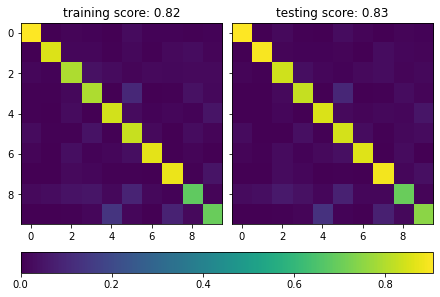

In [93]:
cms_batch, scores_batch = compare_mc_perf(mc_batch, train_X, train_y, test_X, test_y)
plot_perf(cms_batch, scores_batch, "confusion_matrix_batch.png")
plt.savefig("plots/classifier/confusion_matrix_b100.png")

In [94]:
mc_batch300 = MultiClass()
mc_batch300.fit(train_X, onehot, hidden=300, nb_iter=1000, gradient_step=1e-2, batch_size=1000)

early stopping activated


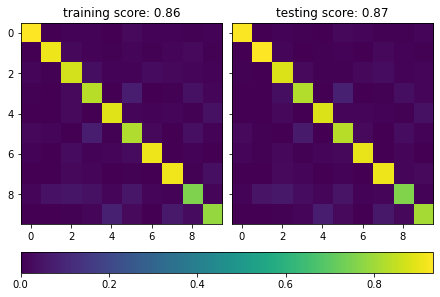

In [95]:
cms_batch300, scores_batch300 = compare_mc_perf(mc_batch300, train_X, train_y, test_X, test_y)
plot_perf(cms_batch300, scores_batch300, "confusion_matrix_batch300.png")
plt.savefig("plots/classifier/confusion_matrix_b300.png")

Sur ce problème, la descente de gradient stochastique (SGD) permet d'obtenir des résultats équivalents
(voir meilleurs) 50x plus rapidement.

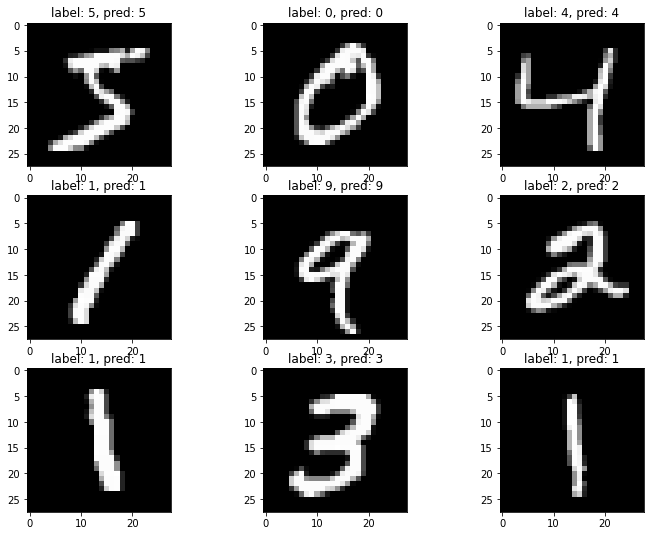

In [96]:
pred_y = mc_batch300.predict(train_X)

plt.figure(figsize=(12, 9))
for i in range(9):
    plt.subplot(330 + 1 + i)
    show_mnist(train_X[i])
    plt.title(f"label: {train_y[i]}, pred: {pred_y[i]}")

plt.savefig("plots/classifier/example_pred")
plt.show()

## MLP

Dans cette partie nous nous attaquons à un problème essentiel de l’informatique, la compression de données (ici sous forme d'images). C’est un problème qui revient à conserver au maximum l’entropie dans un minimum de d’information. 


In [49]:
(train_X, train_y), (test_X, test_y) = load_mnist()
onehot = to_onehot(train_y)

train_X.shape

(60000, 784)

Nous entrainons d'abord un classifieur qui nous permettra de tester les performances des auto-encodeurs.

In [4]:
mc = MultiClass()
mc.fit(train_X, onehot, hidden=256, nb_iter=2000, gradient_step=1e-2, batch_size=1000, early_stop=1e-6)

print(f"Training classification score : {mc.score(train_X, train_y)}")
print(f"Testing classification score : {mc.score(test_X, test_y)}")

C:\Users\Jules Dubreuil\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3515: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\Jules Dubreuil\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training classification score : 0.8915
Testing classification score : 0.8972


### Auto-encoder

Les auto-encodeurs ci-dessous possèdent une architecture de la forme :

- partie encodage : `Linear(784,256) → TanH() → Linear(256,XX) → TanH()`
- partie décodage : `Linear(XX,256) → TanH() → Linear(256,784) → Sigmoid()`

`XX` représente la dimension de la représentation latente.
Les deux parties étant combinées dans un unique module séquentiel.

Nous comparons ici 3 tailles de représentation latente : 128, 28, 10. Nos tests ont permis de determiner qu'un pas de gradient plus faible (`5e-5`) était plus adapté aux espaces latents de plus grande dimension (128, 28). `1e-4` ou `2e-4` conviennent mieux pour des espaces petits (~10).

In [13]:
# ESPACE LATENT DE 128

ae128 = AutoEncoder()
ae128.fit(train_X, train_X, hidden=[256], latent=128, nb_iter=3000, gradient_step=5e-5, batch_size=500, early_stop=None)

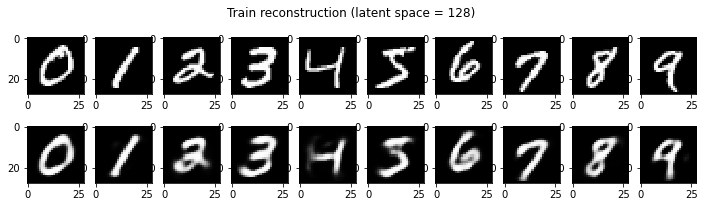

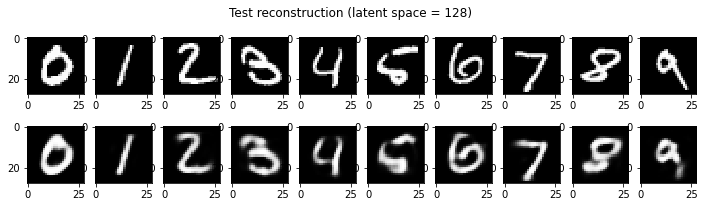

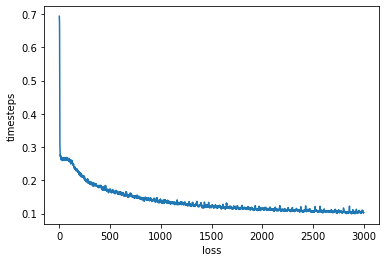

Training reconstruction score : 0.8849833333333333
Test reconstruction score : 0.8897


In [50]:
analyse_compression(ae128, train_X, train_y, title="Train reconstruction (latent space = 128)", dtype="mnist")
analyse_compression(ae128, test_X, test_y, title="Test reconstruction (latent space = 128)", dtype="mnist")

plot_loss(ae128.train_losses, title="MNIST Auto-encoder loss (BCE, latent=128)")

print(f"Training reconstruction score : {mc.score(ae128.predict(train_X), train_y)}")
print(f"Test reconstruction score : {mc.score(ae128.predict(test_X), test_y)}")

In [12]:
# ESPACE LATENT DE 28

ae28 = AutoEncoder()
ae28.fit(train_X, train_X, hidden=[256], latent=28, nb_iter=3000, gradient_step=5e-5, batch_size=500, early_stop=None)

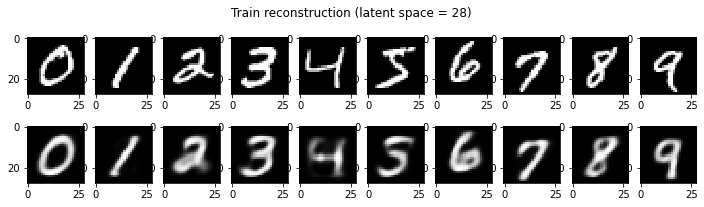

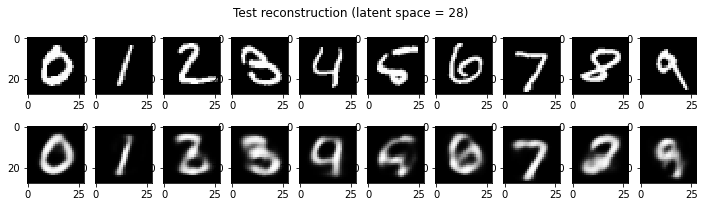

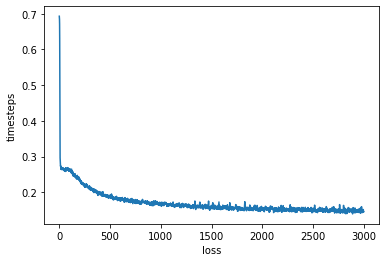

Training reconstruction score : 0.8503166666666667
Testing reconstruction score : 0.8539


In [51]:
analyse_compression(ae28, train_X, train_y, title="Train reconstruction (latent space = 28)", dtype="mnist")
analyse_compression(ae28, test_X, test_y, title="Test reconstruction (latent space = 28)", dtype="mnist")

plot_loss(ae28.train_losses, title="MNIST Auto-encoder loss (BCE, latent=28)")

print(f"Training reconstruction score : {mc.score(ae28.predict(train_X), train_y)}")
print(f"Testing reconstruction score : {mc.score(ae28.predict(test_X), test_y)}")

In [11]:
# ESPACE LATENT DE 10

ae10 = AutoEncoder()
ae10.fit(train_X, train_X, hidden=[256], latent=10, nb_iter=3000, gradient_step=2e-4, batch_size=500, early_stop=None)

C:\Users\Jules Dubreuil\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3515: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\Jules Dubreuil\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


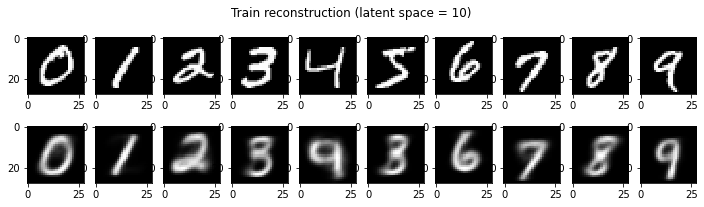

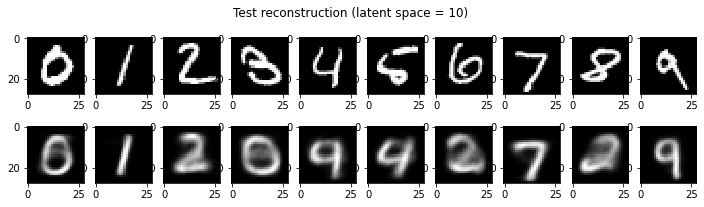

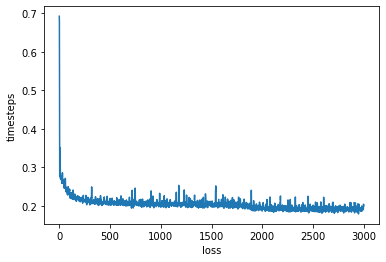

0.6521333333333333
0.6565


In [52]:
analyse_compression(ae10, train_X, train_y, title="Train reconstruction (latent space = 10)", dtype="mnist")
analyse_compression(ae10, test_X, test_y, title="Test reconstruction (latent space = 10)", dtype="mnist")

plot_loss(ae10.train_losses, title="MNIST Auto-encoder loss (BCE, latent=10)")

print(f"Training reconstruction score : {mc.score(ae10.predict(train_X), train_y)}")
print(f"Testing reconstruction score : {mc.score(ae10.predict(test_X), test_y)}")

**Résumé**

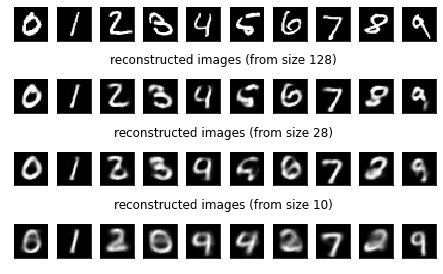

In [35]:
datax, datay = test_X, test_y
decoded128 = ae128.predict(datax)
decoded28 = ae28.predict(datax)
decoded10 = ae10.predict(datax)

rd = "reconstructed images (from size"
titles = ["original images", rd + " 128)", rd + " 28)", rd + " 10)"]
datas = [datax, decoded128, decoded28, decoded10]

examples = [np.where(datay == i)[0][0] for i in range(10)]

fig = plt.figure(constrained_layout=True)
subfigs = fig.subfigures(4, 1)

for subfig, title, data in zip(subfigs.flat, titles, datas):
    subfig.suptitle(title)
    axs = subfig.subplots(1, 10)
    for i, (ax, x) in enumerate(list(zip(axs.flat, examples))):
        ax.imshow(data[x].reshape(28, 28), interpolation="nearest", cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("plots/autoencoder/reconstruted_images.png")
plt.show()

On remarque, comme attendu, que plus l’espace latent est grand plus les résultats sont fidèles au modèle à reproduire.
Cependant cela signifie aussi que l’on a pas minimisé la taille de notre encodage. De plus pour ce type d’image on peut supposer que l’importance n’est pas dans la reproduction de l’image mais plutôt dans sa capacité à retrouver la classe à laquelle appartient l’image afin de reconstruire une image représentative de la classe. 

### Denoiser

Nous avons testé l’impact du bruit sur la qualité de notre encodeur (128 en espace latent) pour donner une bonne représentation. Il s’est avéré assez performant (meilleur que "nous" sur les images très bruitées). En effet la où l'on peine à distinguer les forme à 50% il semble encore capable de représenter la classe de l’image sur la majorité d’entre elles.

In [14]:
# 25% NOISE

noise_amount = 0.25
train_Xnoised25 = noise_data(train_X, noise_amount)
test_Xnoised25 = noise_data(test_X, noise_amount)

ae_noise25 = AutoEncoder()
ae_noise25.fit(train_Xnoised25, train_X, hidden=[256], latent=128, nb_iter=2000, gradient_step=5e-5, batch_size=500, early_stop=None)

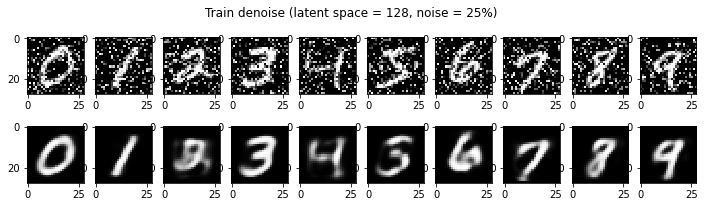

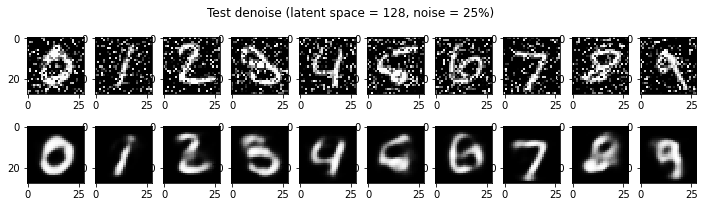

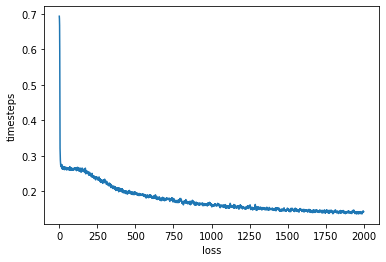

0.8664
0.8725


In [36]:
analyse_compression(ae_noise25, train_Xnoised25, train_y, title="Train denoise (latent space = 128, noise = 25%)", dtype="mnist")
analyse_compression(ae_noise25, test_Xnoised25, test_y, title="Test denoise (latent space = 128, noise = 25%)", dtype="mnist")

plot_loss(ae_noise25.train_losses, title="MNIST Denoiser loss (BCE, latent=128, noise=25%)")

print(f"Training denoising score : {mc.score(ae_noise25.predict(train_X), train_y)}")
print(f"Testing denoising score : {mc.score(ae_noise25.predict(test_X), test_y)}")

In [15]:
# 50% NOISE

noise_amount = 0.5
train_Xnoised50 = noise_data(train_X, noise_amount)
test_Xnoised50 = noise_data(test_X, noise_amount)

ae_noise50 = AutoEncoder()
ae_noise50.fit(train_Xnoised50, train_X, hidden=[256], latent=128, nb_iter=2000, gradient_step=5e-5, batch_size=500, early_stop=None)

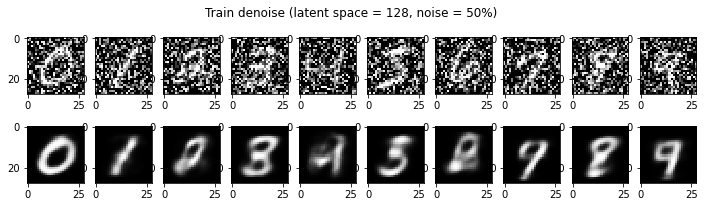

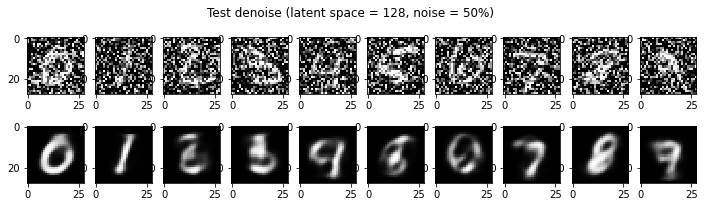

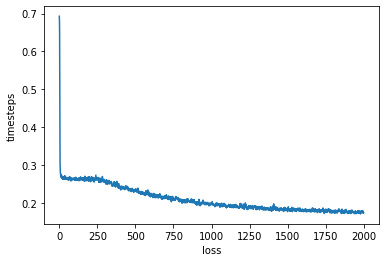

0.8198333333333333
0.8274


In [38]:
analyse_compression(ae_noise50, train_Xnoised50, train_y, title="Train denoise (latent space = 128, noise = 50%)", dtype="mnist")
analyse_compression(ae_noise50, test_Xnoised50, test_y, title="Test denoise (latent space = 128, noise = 50%)", dtype="mnist")

plot_loss(ae_noise50.train_losses, title="MNIST Denoiser loss (BCE, latent=128, noise=50%)")

print(f"Training denoising score : {mc.score(ae_noise50.predict(train_X), train_y)}")
print(f"Test denoising score : {mc.score(ae_noise50.predict(test_X), test_y)}")

In [16]:
# 75% NOISE

noise_amount = 0.75
train_Xnoised75 = noise_data(train_X, noise_amount)
test_Xnoised75 = noise_data(test_X, noise_amount)

ae_noise75 = AutoEncoder()
ae_noise75.fit(train_Xnoised75, train_X, hidden=[256], latent=128, nb_iter=2000, gradient_step=5e-5, batch_size=500, early_stop=None)

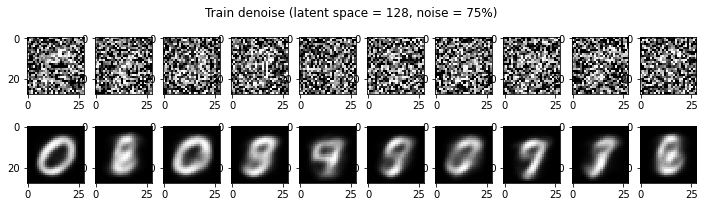

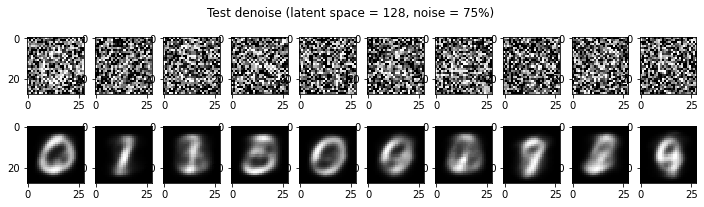

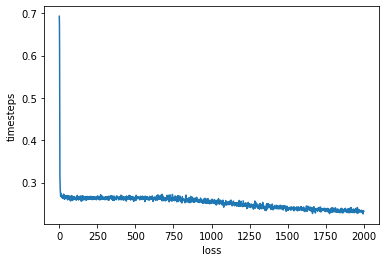

0.6329833333333333
0.635


In [39]:
analyse_compression(ae_noise75, train_Xnoised75, train_y, title="Train denoise (latent space = 128, noise = 75%)", dtype="mnist")
analyse_compression(ae_noise75, test_Xnoised75, test_y, title="Test denoise (latent space = 128, noise = 75%)", dtype="mnist")

plot_loss(ae_noise75.train_losses, title="MNIST Denoiser loss (BCE, latent=128, noise=75%)")

print(f"Training denoising score : {mc.score(ae_noise75.predict(train_X), train_y)}")
print(f"Testing denoising score : {mc.score(ae_noise75.predict(test_X), test_y)}")

In [42]:
datax, datay = test_X, test_y
denoised25 = ae_noise25.predict(test_Xnoised25)
denoised50 = ae_noise50.predict(test_Xnoised50)
denoised75 = ae_noise75.predict(test_Xnoised75)

In [67]:
def plot_denoiser(noised_X, denoised, title=""):
    plt.figure(figsize=(4, 3))
    for i in range(3):
        plt.subplot(230 + 1 + i)
        show_mnist(noised_X[i])
        plt.subplot(230 + 4 + i)
        show_mnist(denoised[i])

    plt.suptitle(title)
    plt.show()

**Résumé**

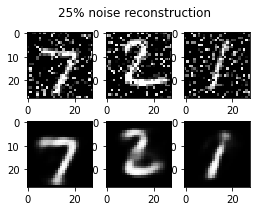

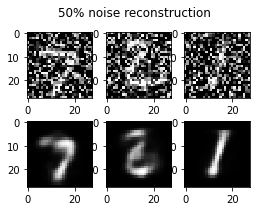

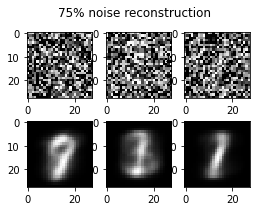

In [69]:
plot_denoiser(test_Xnoised25, denoised25, title="25% noise reconstruction")
plot_denoiser(test_Xnoised50, denoised50, title="50% noise reconstruction")
plot_denoiser(test_Xnoised75, denoised75, title="75% noise reconstruction")

### USPS

Notre auto-encodeur marche aussi avec les données USPS. Nous en avons profité pour
comparer les performances entre BCE et MSE.

In [53]:
train_X, train_y = load_usps("../data/USPS_train.txt")
test_X, test_y = load_usps("../data/USPS_test.txt")
onehot = to_onehot(train_y)

In [55]:
mc_usps = MultiClass()
mc_usps.fit(train_X, onehot, hidden=128, nb_iter=1000, gradient_step=1e-2, batch_size=500, early_stop=1e-4)

print(f"Training classification score : {mc_usps.score(train_X, train_y)}")
print(f"Testing classification score : {mc_usps.score(test_X, test_y)}")

early stopping activated
Training classification score : 0.8976820737896036
Testing classification score : 0.8589935226706528


In [56]:
ae_usps_bce = AutoEncoder()
ae_usps_bce.fit(train_X, train_X, hidden=[100], latent=10, nb_iter=4000, gradient_step=1e-4, batch_size=730, early_stop=5e-6)

early stopping activated


In [70]:
usps_decoded = ae_usps_bce.predict(test_X)

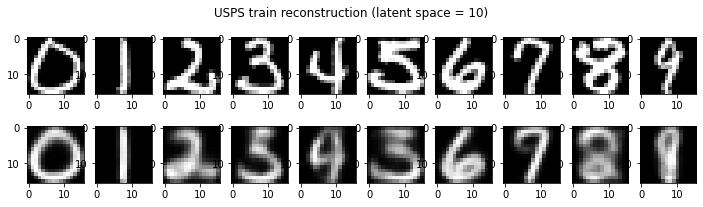

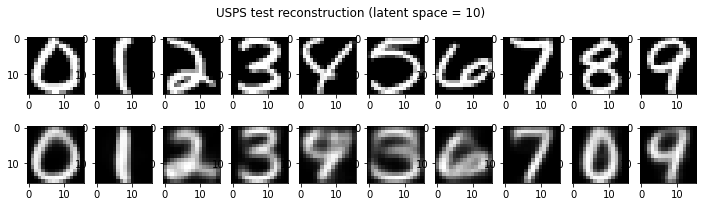

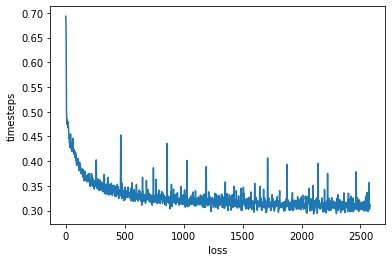

Training reconstruction score : 0.7635440954601563
Testing reconstruction score : 0.7229696063776782


In [70]:
analyse_compression(ae_usps_bce, train_X, train_y, title="USPS train reconstruction (latent space = 10)", dtype="usps")
analyse_compression(ae_usps_bce, test_X, test_y, title="USPS test reconstruction (latent space = 10)", dtype="usps")

plot_loss(ae_usps_bce.train_losses, title="USPS Auto-encoder loss (BCE, latent=10)")

print(f"Training reconstruction score : {mc_usps.score(ae_usps_bce.predict(train_X), train_y)}")
print(f"Testing reconstruction score : {mc_usps.score(ae_usps_bce.predict(test_X), test_y)}")

In [72]:
ae_usps_mse = AutoEncoder(loss=MSELoss())
ae_usps_mse.fit(train_X, train_X, hidden=[100], latent=10, nb_iter=4000, gradient_step=1e-4, batch_size=730, early_stop=5e-6)

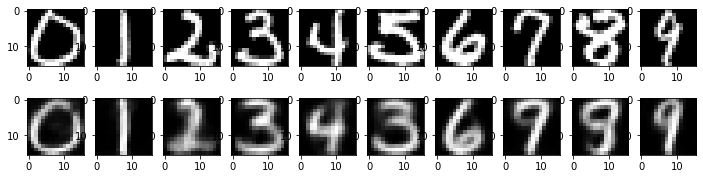

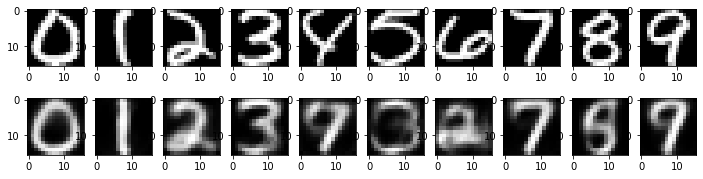

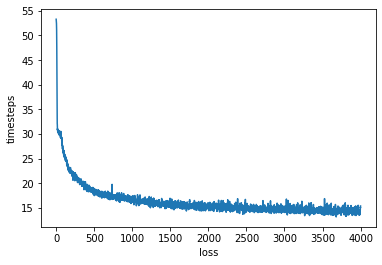

Training reconstruction score : 0.7340556850912083
Testing reconstruction score : 0.6910812157448929


In [73]:
analyse_compression(ae_usps_mse, train_X, train_y, dtype="usps")
analyse_compression(ae_usps_mse, test_X, test_y, dtype="usps")

plot_loss(ae_usps_mse.train_losses, title="USPS Auto-encoder loss (MSE, latent=10)")

print(f"Training reconstruction score : {mc_usps.score(ae_usps_mse.predict(train_X), train_y)}")
print(f"Testing reconstruction score : {mc_usps.score(ae_usps_mse.predict(test_X), test_y)}")

Le classifieur ne trouve pas de grandes différences entre les 2 loss. MSE a plus tendance à
"baver" puisqu'il cherche a moyenner, tandis que BCE tente de pousser vers 0 et 1.

La réduction du bruit (30%) n'est pas trop mauvaise sur USPS avec un espace latent de 10.

In [74]:
noise_amount = 0.3
train_Xnoised = noise_data(train_X, noise_amount)
test_Xnoised = noise_data(test_X, noise_amount)

ae_usps_noise = AutoEncoder()
ae_usps_noise.fit(train_Xnoised, train_X, hidden=[100], latent=10, nb_iter=4000, gradient_step=1e-4, batch_size=730, early_stop=1e-6)

early stopping activated


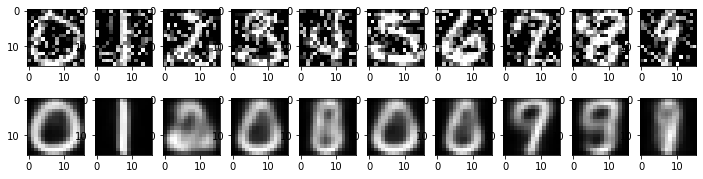

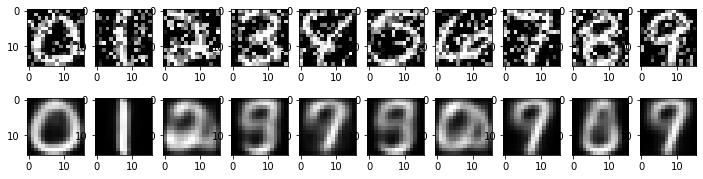

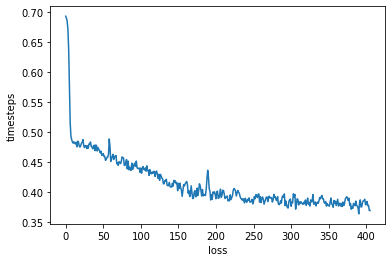

Training denoising score : 0.4842957070360719
Testing denoising score : 0.4798206278026906


In [75]:
analyse_compression(ae_usps_noise, train_Xnoised, train_y, dtype="usps")
analyse_compression(ae_usps_noise, test_Xnoised, test_y, dtype="usps")

plot_loss(ae_usps_noise.train_losses, title="USPS Denoiser loss (BCE, latent=10, noise=30%)")

print(f"Training denoising score : {mc_usps.score(ae_usps_noise.predict(train_X), train_y)}")
print(f"Testing denoising score : {mc_usps.score(ae_usps_noise.predict(test_X), test_y)}")

### Representation visualisation (t-SNE)

Nous avons visualisé la représentation des espaces latents avec t-SNE.

In [58]:
input = test_X
for module in ae_usps_bce.net._modules[:4]:
    input = module.forward(input)

encoded = input

In [60]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

def tsne(datax, perplexities):
    tsnes = [
        TSNE(
            n_components=2,
            init="random",
            random_state=0,
            perplexity=perplexity,
            learning_rate="auto",
            n_iter=300,
        )
        for perplexity in perplexities
    ]
    return [tsne.fit_transform(datax) for tsne in tsnes]


def plot_tsne(embedded_datas, pred, perplexities):
    fig = plt.figure(figsize=(16, 4), constrained_layout=True)

    axes = fig.subplots(nrows=1, ncols=4, sharey=True)
    for i, ax in enumerate(axes):
        im = ax.scatter(embedded_datas[i][:, 0], embedded_datas[i][:, 1], c=pred)
        ax.set_title(f"Perplexity {perplexities[i]}")

    fig.colorbar(im, ax=axes, location="right")
    plt.show()

In [62]:
perplexities = [5, 30, 50, 86]

kmeans = KMeans(
    n_clusters=10,
    init="k-means++",
    n_init=10,
    max_iter=300,
    tol=0.0001,
    random_state=0,
)

init_pred = kmeans.fit_predict(test_X)
enco_pred = kmeans.fit_predict(encoded)

In [63]:
embedded_init = tsne(test_X, perplexities=perplexities)
embedded_deco = tsne(encoded, perplexities=perplexities)

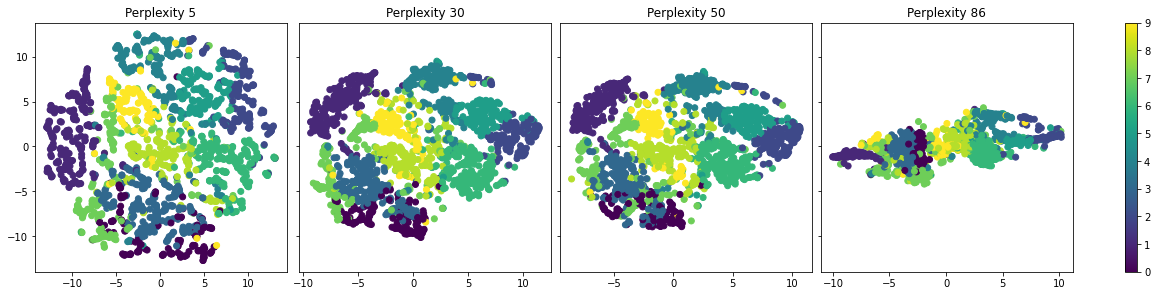

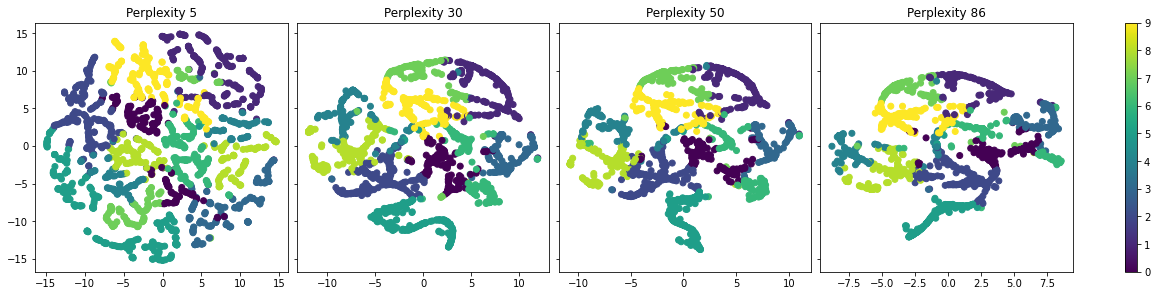

In [64]:
plot_tsne(embedded_init, init_pred, perplexities)
plot_tsne(embedded_deco, enco_pred, perplexities)

Les résultats sont assez instructifs car ils permettent de visualiser assez simplement les différents clusters qui correspondent aux différentes classes. Les clusters qui s'entremêlent sont ceux qui sont proches en image (3 et 5, 7 et 9). Cela est confirmé par les erreurs généralement faites par le réseau.

## Convolution

La dernière partie sur les réseaux de neurones convolutionnels (CNN) était de loin la plus difficile. Surtout concernant la minimisation des boucles python. C’est pour cela que nous n’avons pas eu le temps d'expérimenter en profondeur les possibilités offertes par ce type de réseau.

In [76]:
train_X, train_y = load_usps("../data/USPS_train.txt")
test_X, test_y = load_usps("../data/USPS_test.txt")

(train_batch, length), test_batch = train_X.shape, test_X.shape[0]
train_X = train_X.reshape(train_batch, length, 1)
test_X = test_X.reshape(test_batch, length, 1)

onehot = to_onehot(train_y)
train_X.shape

(7291, 256, 1)

In [87]:
conv = Convolutional()
conv.fit(train_X, onehot, gradient_step=1e-4, nb_iter=60, batch_size=500)

In [88]:
print(f"training score : {conv.score(train_X, train_y)}")
print(f"testing score : {conv.score(test_X, test_y)}")

training score : 0.48374708544781236
testing score : 0.47832585949177875


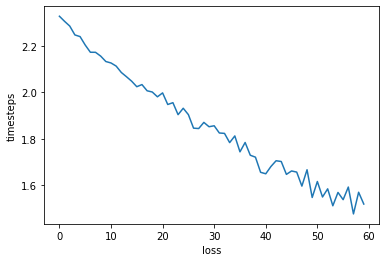

In [89]:
plot_loss(conv.train_losses)

Il semblerait tout de même qu'au vu de l'évolution de la loss, notre réseau est capable d’apprendre. De plus, nous avons vérifié les calculs des `forward` de chacunes des couches en les comparant avec les `forward` de PyTorch. Nous pensons qu’il reste cependant quelques bugs dans notre implémentation sur cette partie.

# Conclusion

Lors de ce projet nous avons beaucoup appris. Nous sommes allés en profondeur dans les réseaux de neurones, ce qui permet une bien meilleure compréhension du système dans sa globalité.

De plus nous avons essayé de jouer le jeu au maximum en essayant de faire le moins de boucles possibles (aucune boucle imbriquée dans tout le code). Cela a rendu la tâche beaucoup plus ardue mais aussi plus formatrice sur les capacités de Numpy. Nous ressortons beaucoup plus à l'aise dans le domaine.


Cependant nous regrettons de ne pas avoir eu plus de temps d'implémenter la suite des fonctions de convolutions (ConvD) car le sujet nous intéressait beaucoup.